Figure 4  

Correlation between flash detection accuracy and BIC scores (Bayesian Causal Inference Model Fitting)

In [1]:
# Imports
import os
import importlib
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


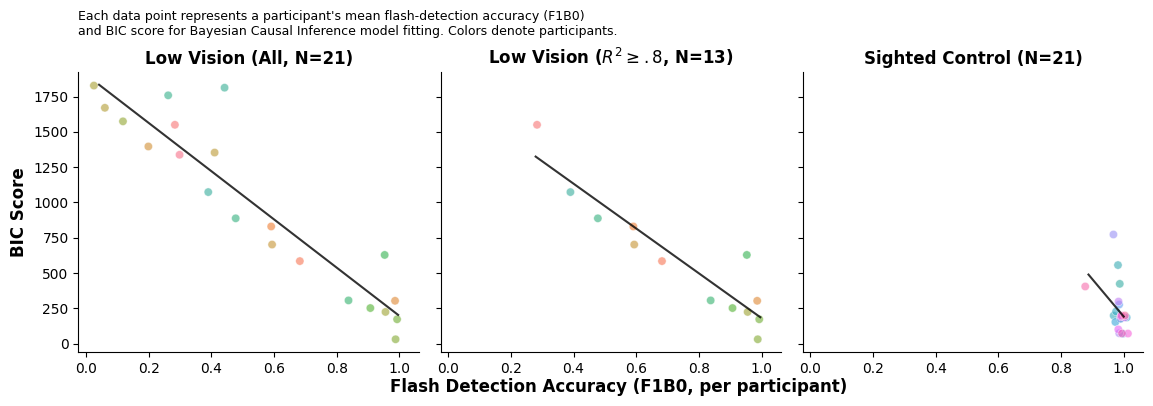

In [2]:
df = pd.read_csv('csv/all_participants.csv')
bci_df = pd.read_csv('csv/modeling/outputs/bci_best_models.csv')

# only keep location=='raw'
bci_df = bci_df[bci_df['location']=='raw']
bci_df = bci_df.rename(columns={'subject_id': 'sid'})

f1b0 = df[(df['n_flash']==1) & (df['n_beep']==0)]
flash_acc = (
    f1b0.groupby(['sid', 'group'])['accuracy']
    .mean()
    .reset_index()
)

final_df = flash_acc.merge(bci_df, on=['sid'], how='left')

final_df['acc_plotting'] = final_df['accuracy'] + np.random.normal(0, 0.01, len(final_df))

LV_to_include = ['LV002', 'LV003', 'LV005', 'LV007', 'LV009',
                 'LV015', 'LV017', 'LV018', 'LV019', 'LV020',
                 'LV021', 'LV022', 'LV025']

final_df['group_plot'] = final_df['group_x']

final_df.loc[final_df['group_plot'] == 'Low Vision', 'group_plot'] = 'Low Vision (all)'

lv_inc = final_df[final_df['group_plot'] == 'Low Vision (all)'].copy()
lv_inc = lv_inc[lv_inc['sid'].isin(LV_to_include)]
lv_inc['group_plot'] = 'Low Vision (to include)'

plot_df = pd.concat([final_df, lv_inc], ignore_index=True)
col_order = ['Low Vision (all)', 'Low Vision (to include)', 'Sighted Control']

g = sns.relplot(
    data=plot_df,
    x='acc_plotting',
    y='bic',
    hue='sid',
    col='group_plot',
    col_order=col_order,
    kind='scatter',
    height=4,
    aspect=.9,
    alpha=0.6,
    legend=False
)

# Add regression lines
g.map_dataframe(
    sns.regplot,
    x='accuracy',
    y='bic',
    scatter=False,
    color='black',
    ci=None,
    line_kws={'linewidth': 1.5, 'alpha': 0.8}
)

fontsize = 12
g.figure.subplots_adjust(left=0, top=0.8, bottom=0.1)

titles = [
    "Low Vision (All, N=21)", 
    r"Low Vision ($R^2 \geq .8$, N=13)", 
    "Sighted Control (N=21)"
]

for i, ax in enumerate(g.axes.flat):
    ax.set_xlabel('')
    ax.set_ylabel('BIC Score', fontsize=fontsize, fontweight='bold')
    ax.set_title(titles[i], fontsize=fontsize, fontweight='bold')

g.figure.text(
    0.5, 0,
    "Flash Detection Accuracy (F1B0, per participant)",
    ha='center', fontsize=fontsize, fontweight='bold'
)
# g.figure.text(
#     0.5, 1,
#     "Correlation between Flash Detection Accuracy and BIC Scores (Model Performance)",
#     ha='center', fontsize=fontsize, fontweight='bold'
# )
g.figure.text(
    0, 0.92,
    "Each data point represents a participant's mean flash-detection accuracy (F1B0)\n"
    "and BIC score for Bayesian Causal Inference model fitting. Colors denote participants.",
    ha='left', va='center', fontsize=9
)

plt.show()


In [3]:
from scipy.stats import pearsonr

corr_results = []

for grp, subset in plot_df.groupby(['group_plot']):
    # drop NaNs
    valid = subset.dropna(subset=['accuracy', 'bic'])
    if len(valid) > 1:
        r, p = pearsonr(valid['accuracy'], valid['bic'])
        corr_results.append({'group_x': grp, 'r': r.round(2), 'p': p.round(2), 'n': len(valid)})
    else:
        corr_results.append({'group_x': grp, 'r': None, 'p': None, 'n': len(valid)})

corr_df = pd.DataFrame(corr_results)
corr_df

,group_x,r,p,n
0,"(Low Vision (all),)",-0.93,0.00,21
1,"(Low Vision (to include),)",-0.93,0.00,13
2,"(Sighted Control,)",-0.39,0.08,21
